<a href="https://colab.research.google.com/github/chitvan101/Crime_Analysis/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
#spark imports
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import csv
from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when
import pyspark.sql.functions as F

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [6]:
#test CPU type
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
#change RAM allocation, current = 20GB
#change Core allocation, current = 3 Cores

spark = SparkSession.builder.appName("Project - Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "20g")\
.config("spark.driver.cores", '3')\
.getOrCreate()

In [8]:
crimes_schema = StructType([StructField("ID", IntegerType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", IntegerType(), True),
                            StructField("District", IntegerType(), True),
                            StructField("Ward", IntegerType(), True),
                            StructField("Community Area", IntegerType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", IntegerType(), True),
                            StructField("Y Coordinate", IntegerType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", StringType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])


In [9]:
data = spark.read.csv('/content/drive/MyDrive/Book1.csv',header = True,schema = crimes_schema)

In [10]:
data.head(5)

[Row(ID=10224738, Case Number='HY411648', Date='09-05-2015 13:30', Block='043XX S WOOD ST', IUCR='486', Primary Type='BATTERY', Description='DOMESTIC BATTERY SIMPLE', Location Description='RESIDENCE', Arrest=False, Domestic=True, Beat=924, District=9, Ward=12, Community Area=61, FBI Code='08B', X Coordinate=1165074, Y Coordinate=1875917, Year=2015, Updated On='02-10-2018 15:50', Latitude=41.81511728, Longitude=-87.66999956, Location='(41.815117282, -87.669999562)'),
 Row(ID=10224739, Case Number='HY411615', Date='09-04-2015 11:30', Block='008XX N CENTRAL AVE', IUCR='870', Primary Type='THEFT', Description='POCKET-PICKING', Location Description='CTA BUS', Arrest=False, Domestic=False, Beat=1511, District=15, Ward=29, Community Area=25, FBI Code='6', X Coordinate=1138875, Y Coordinate=1904869, Year=2015, Updated On='02-10-2018 15:50', Latitude=41.89508047, Longitude=-87.76540045, Location='(41.895080471, -87.765400451)'),
 Row(ID=11646166, Case Number='JC213529', Date='09-01-2018 00:01',

In [11]:
dataset = data.filter((data['Year'] >2009) & (data['Year'] !=2022))

In [12]:
#dropping columns which non-relative 

dataset = dataset.drop('ID')
dataset = dataset.drop('Case Number')
dataset = dataset.drop('FBI Code')
dataset = dataset.drop('Updated On')
dataset = dataset.drop('IUCR')
dataset = dataset.drop('X Coordinate')
dataset = dataset.drop('Y Coordinate')
dataset = dataset.drop('Location')
dataset = dataset.drop('Description')
dataset = dataset.drop('Domestic')

In [13]:
primaryCount = dataset.groupby('Primary Type').count()
primaryCount.orderBy('count', ascending=False).show()

+--------------------+-----+
|        Primary Type|count|
+--------------------+-----+
|               THEFT|22263|
|             BATTERY|18127|
|     CRIMINAL DAMAGE|11175|
|           NARCOTICS| 7728|
|  DECEPTIVE PRACTICE| 6665|
|       OTHER OFFENSE| 6587|
|             ASSAULT| 6262|
|            BURGLARY| 5355|
|             ROBBERY| 3912|
| MOTOR VEHICLE THEFT| 3853|
|   CRIMINAL TRESPASS| 2278|
|   WEAPONS VIOLATION| 1314|
|OFFENSE INVOLVING...|  903|
|PUBLIC PEACE VIOL...|  843|
| CRIM SEXUAL ASSAULT|  596|
|INTERFERENCE WITH...|  501|
|         SEX OFFENSE|  438|
|        PROSTITUTION|  406|
|               ARSON|  187|
|            GAMBLING|  124|
+--------------------+-----+
only showing top 20 rows



In [14]:
print('Distinct primary types '+ str(primaryCount.distinct().count()))

Distinct primary types 33


In [15]:
dataset = dataset.filter((dataset['Primary Type']!='STALKING')&
                             (dataset['Primary Type']!='OBSCENITY')&
                             (dataset['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
                             (dataset['Primary Type']!='GAMBLING')&
                             (dataset['Primary Type']!='NON - CRIMINAL')&
                             (dataset['Primary Type']!='LIQUOR LAW VIOLATION')&
                             (dataset['Primary Type']!='PUBLIC INDECENCY')&
                             (dataset['Primary Type']!='HUMAN TRAFFICKING')&
                             (dataset['Primary Type']!='INTIMIDATION')&
                             (dataset['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
                             (dataset['Primary Type']!='NON-CRIMINAL')&
                             (dataset['Primary Type']!='OTHER NARCOTIC VIOLATION'))


In [16]:
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'CRIM SEXUAL ASSAULT') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'SEX OFFENSE').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'WEAPONS VIOLATION') | \
                                    (dataset["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE VIOLATION').otherwise(dataset['Primary Type']))
dataset=dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'ARSON') ,'CRIMINAL TRESPASS').otherwise(dataset['Primary Type']))


In [17]:
primaryCount = dataset.groupby('Primary Type').count()
primaryCount.orderBy('count', ascending=False).show()

+--------------------+-----+
|        Primary Type|count|
+--------------------+-----+
|               THEFT|22263|
|             BATTERY|18127|
|     CRIMINAL DAMAGE|11175|
|           NARCOTICS| 7728|
|  DECEPTIVE PRACTICE| 6665|
|       OTHER OFFENSE| 6587|
|             ASSAULT| 6262|
|            BURGLARY| 5355|
|             ROBBERY| 3912|
| MOTOR VEHICLE THEFT| 3853|
|PUBLIC PEACE VIOL...| 2658|
|   CRIMINAL TRESPASS| 2465|
|         SEX OFFENSE| 1440|
|OFFENSE INVOLVING...|  903|
|          KIDNAPPING|   76|
|CRIMINAL SEXUAL A...|   18|
|            HOMICIDE|    2|
+--------------------+-----+



In [18]:
print('Distinct primary types after preprocessing '+ str(primaryCount.distinct().count()))

Distinct primary types after preprocessing 17


In [19]:
dataset = dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset = dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset = dataset.withColumn("Month", F.month(dataset.Day))
dataset = dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset = dataset.withColumn("Year", F.year(dataset.Day))
dataset = dataset.na.drop()
dataset = dataset.drop('Date')
dataset = dataset.drop('Day')
dataset.head(5)

[Row(Block='035XX S MICHIGAN AVE', Primary Type='OTHER OFFENSE', Location Description='POLICE FACILITY/VEH PARKING LOT', Arrest=True, Beat=213, District=2, Ward=3, Community Area=35, Year=2014, Latitude=41.83061185, Longitude=-87.62324737, Month=3, WeekDay=5),
 Row(Block='014XX S MICHIGAN AVE', Primary Type='THEFT', Location Description='RESIDENCE-GARAGE', Arrest=False, Beat=131, District=1, Ward=2, Community Area=33, Year=2015, Latitude=41.86323513, Longitude=-87.62406127, Month=8, WeekDay=1),
 Row(Block='065XX N MAPLEWOOD AVE', Primary Type='THEFT', Location Description='STREET', Arrest=False, Beat=2412, District=24, Ward=50, Community Area=2, Year=2015, Latitude=42.00032784, Longitude=-87.69361533, Month=8, WeekDay=3),
 Row(Block='039XX N LECLAIRE AVE', Primary Type='THEFT', Location Description='STREET', Arrest=False, Beat=1634, District=16, Ward=45, Community Area=15, Year=2020, Latitude=41.95205195, Longitude=-87.75466037, Month=3, WeekDay=3),
 Row(Block='014XX W BARRY AVE', Prim

In [20]:
dataset=dataset.na.drop()

In [21]:
data = dataset.toPandas()

In [22]:
data.columns

Index(['Block', 'Primary Type', 'Location Description', 'Arrest', 'Beat',
       'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude',
       'Month', 'WeekDay'],
      dtype='object')

In [24]:
primaryVisualizeDF = data.groupby('Primary Type').size()

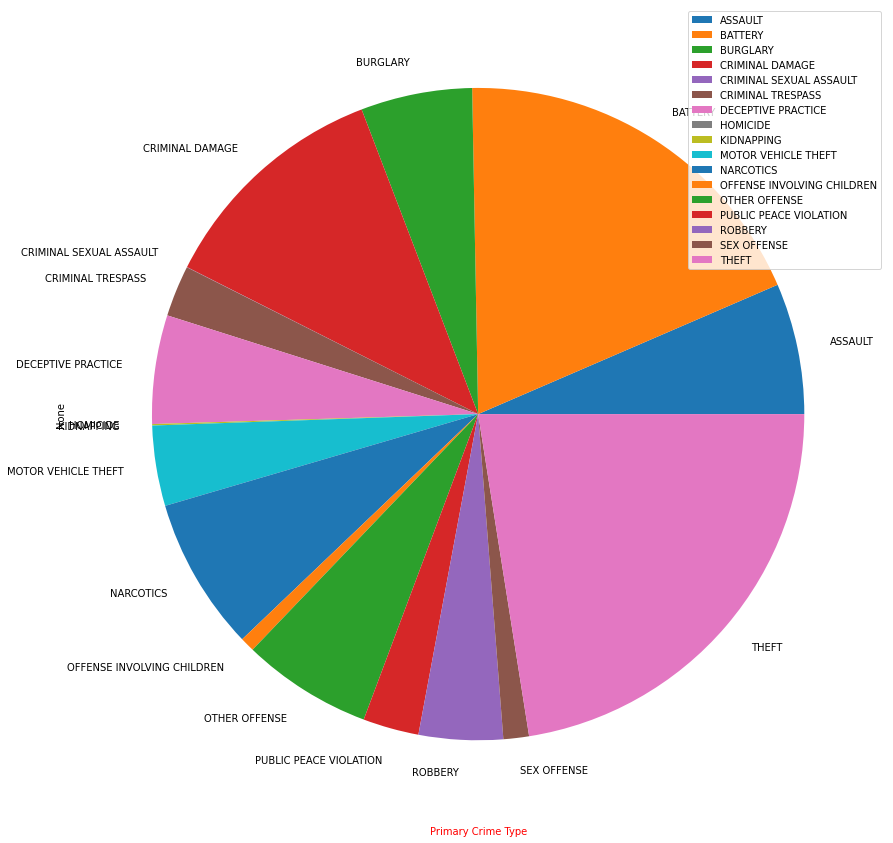

In [25]:
primaryVisualizeDF.plot.pie(figsize = (15,15))
plt.xlabel('Primary Crime Type', fontsize=10, color = 'red')
plt.legend()

In [26]:
data = data.replace(to_replace='None', value=np.nan).dropna()

In [27]:
# create an instance of label encoder for categorical variables
labelEncoder = LabelEncoder()
primaryEncoded = labelEncoder.fit_transform(data['Primary Type'])
primaryEncoded

array([12, 16, 16, ..., 16,  3,  3])

In [28]:
data['Primary Type'] = primaryEncoded
# create an instance of label encoder for categorical variables
labelEncoder2 = LabelEncoder()
locDiscEncoded = labelEncoder2.fit_transform(data['Location Description'])
locDiscEncoded

array([ 81,  88, 100, ...,  78, 100,  83])

In [29]:
data['Location Description'] = locDiscEncoded
# create an instance of label encoder for categorical variables
labelEncoder3 = LabelEncoder()
blockEncoded = labelEncoder2.fit_transform(data['Location Description'])
blockEncoded

array([ 81,  88, 100, ...,  78, 100,  83])

In [30]:
data['Block'] = locDiscEncoded

In [31]:
#Use PCA to combine features

from sklearn.decomposition import PCA
location = data[['Latitude','Longitude']]
pca = PCA(n_components=1,random_state=123)
loc = pca.fit_transform(location)
data['Location'] = loc
data.head(5)

,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Month,WeekDay,Location
0,81,12,81,True,213,2,3,35,2014,41.830612,-87.623247,3,5,-0.032389
1,88,16,88,False,131,1,2,33,2015,41.863235,-87.624061,8,1,-0.003202
2,100,16,100,False,2412,24,50,2,2015,42.000328,-87.693615,8,3,0.150498
3,100,16,100,False,1634,16,45,15,2020,41.952052,-87.754660,3,3,0.136527
4,100,16,100,False,1933,19,32,6,2015,41.937926,-87.664880,8,2,0.081909


In [32]:
#taking a fraction of data
data_sample = data.sample(frac=0.1, random_state=123)

In [33]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()

In [34]:
X = data_sample.loc[:, data.columns != 'Primary Type']

model.fit(X,data_sample['Primary Type'])

ExtraTreesClassifier()

In [35]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.07913887 0.07992958 0.03789447 0.08777579 0.03120289 0.05979207
 0.05591777 0.0068475  0.12256721 0.12399852 0.09405155 0.09943651
 0.12144725]


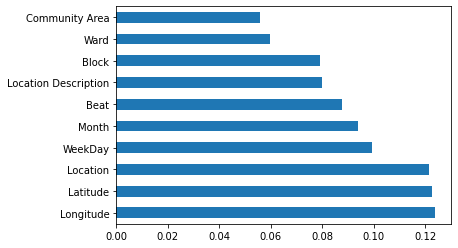

In [36]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#plot for top 10 features
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [37]:
corelation = data.corr()
corelation

,Block,Primary Type,Location Description,Arrest,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Month,WeekDay,Location
Block,1.000000,0.126295,1.000000,0.047229,0.024191,0.024633,-0.004549,0.002456,0.001416,-0.024092,-0.024064,0.001582,-0.008138,-0.012232
Primary Type,0.126295,1.000000,0.126295,0.050359,0.033639,0.033450,0.069341,-0.085540,-0.007844,0.094528,-0.002764,-0.004713,0.009419,0.076902
Location Description,1.000000,0.126295,1.000000,0.047229,0.024191,0.024633,-0.004549,0.002456,0.001416,-0.024092,-0.024064,0.001582,-0.008138,-0.012232
Arrest,0.047229,0.050359,0.047229,1.000000,-0.012514,-0.012657,-0.011844,0.025076,-0.008864,-0.025264,-0.040604,0.017826,-0.000348,-0.008256
Beat,0.024191,0.033639,0.024191,-0.012514,1.000000,0.999695,0.677461,-0.488247,0.000677,0.631731,-0.558533,0.005646,0.004797,0.674582
District,0.024633,0.033450,0.024633,-0.012657,0.999695,1.000000,0.678661,-0.488568,0.000637,0.632564,-0.559294,0.005728,0.004891,0.675479
Ward,-0.004549,0.069341,-0.004549,-0.011844,0.677461,0.678661,1.000000,-0.539819,0.000880,0.656007,-0.451811,0.002788,0.014967,0.662376
Community Area,0.002456,-0.085540,0.002456,0.025076,-0.488247,-0.488568,-0.539819,1.000000,-0.003321,-0.782127,0.256529,-0.002038,-0.017361,-0.705795
Year,0.001416,-0.007844,0.001416,-0.008864,0.000677,0.000637,0.000880,-0.003321,1.000000,-0.001743,0.002023,-0.055942,-0.102571,-0.002005
Latitude,-0.024092,0.094528,-0.024092,-0.025264,0.631731,0.632564,0.656007,-0.782127,-0.001743,1.000000,-0.550843,0.005211,0.011331,0.968694


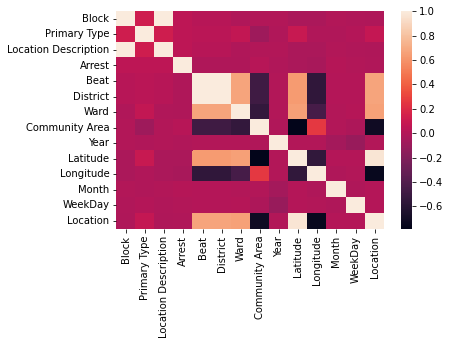

In [38]:
sns.heatmap(corelation)

In [39]:
selected_columns = ['Latitude','Longitude','Location Description','Block','WeekDay']
#selected_columns = ['Latitude','Longitude']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[selected_columns], data['Primary Type'], test_size=0.3) # 70% training and 30% test

In [41]:
knn_5 = KNeighborsClassifier(n_neighbors=5) 
knn_5.fit(X_train,y_train)
pred_train = knn_5.predict(X_train)
pred_i = knn_5.predict(X_test)
print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Test accuracy  0.47420845070422535
Accuracy  0.2748448837943001
F1 score  0.26404733903948097


In [42]:
error_rate = []

krange = range(10,50,5)
for i in krange:
 
 knn = KNeighborsClassifier(n_neighbors=i, metric='manhattan', weights = 'uniform',n_jobs= -1) # haversine - if only lat long
 knn.fit(X_train,y_train)
 pred_train = knn.predict(X_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))
 print('Neighbours ',i)
 print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
 print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
 print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Neighbours  10
Test accuracy  0.4152338028169014
Accuracy  0.30045220317593857
F1 score  0.2746264755143151
Neighbours  15
Test accuracy  0.39055774647887326
Accuracy  0.30697234199179724
F1 score  0.2734354539704108
Neighbours  20
Test accuracy  0.3794929577464789
Accuracy  0.3131769902197918
F1 score  0.2735700845981564
Neighbours  25
Test accuracy  0.36858591549295777
Accuracy  0.32001261962351457
F1 score  0.27620801797571803
Neighbours  30
Test accuracy  0.3634929577464789
Accuracy  0.3204332737406667
F1 score  0.2732897531000902
Neighbours  35
Test accuracy  0.3600450704225352
Accuracy  0.3232201072667999
F1 score  0.2709532885486527
Neighbours  40
Test accuracy  0.358512676056338
Accuracy  0.3232726890314439
F1 score  0.2686079845096781
Neighbours  45
Test accuracy  0.3543887323943662
Accuracy  0.3250604690293406
F1 score  0.2667110965108763


Text(0, 0.5, 'Error Rate')

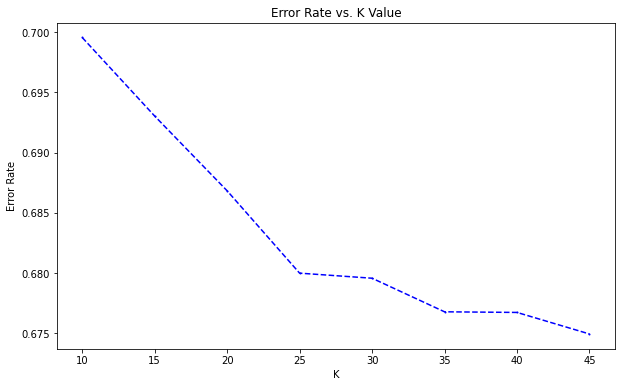

In [43]:
plt.figure(figsize=(10,6))

plt.plot(krange,error_rate, color= 'blue', linestyle= 'dashed', marker= 'o', markerfacecolor='red', markersize=1)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')